# 📊 Exploratory Data Analysis (EDA)

**Objective:** Understand the characteristics of the cleaned dataset before training models.

### 🔍 Key Questions:
1.  **Class Balance:** Are the topics evenly distributed?
2.  **Text Length:** How long are the articles? Are there outliers (too short/long)?
3.  **Vocabulary:** What are the most common words? Are there remaining stop words?
4.  **Data Quality:** Are there any null or duplicate values left?

In [4]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from wordcloud import WordCloud

# --- CONFIGURATION ---
# Adjust path relative to 'notebooks' folder: Go up one level (..) then into data/final
PROJECT_ROOT = Path.cwd().parent
DATA_FILE = PROJECT_ROOT / "data" / "final" / "nlp_dataset.jsonl"

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"📂 Reading data from: {DATA_FILE}")

📂 Reading data from: C:\Users\Admin\PycharmProjects\PythonProject11\data\final\nlp_dataset.jsonl


## 2. Load Data

In [5]:
try:
    df = pd.read_json(DATA_FILE, lines=True)
    print(f"✅ Successfully loaded {len(df)} articles.")
except ValueError:
    print("❌ Error: Could not load data. Check if 'nlp_dataset.jsonl' exists.")

# Quick look
df.head()

✅ Successfully loaded 115188 articles.


text label_name  label_id  \
0  Một trong những phân khu sôi động nhất Hội chợ...    Ẩm thực         0   
1  Chủ đề về ẩm thực Hà thành luôn thu hút sự qua...    Ẩm thực         0   
2  Tự làm bánh mỳ, bánh phở, nhập mắm tôm từ Việt...    Ẩm thực         0   
3  Sóc nhỏ Phnom Pi, xã miền núi Tri Tôn, tỉnh An...    Ẩm thực         0   
4  "Omakase" trong tiếng Nhật mang ý nghĩa "phó t...    Ẩm thực         0   

       filename  
0   AT_DT_1.txt  
1  AT_DT_10.txt  
2  AT_DT_11.txt  
3  AT_DT_12.txt  
4  AT_DT_13.txt

## 3. Class Distribution Analysis
Checking if the dataset is balanced across different topics. Imbalanced data can lead to biased models.

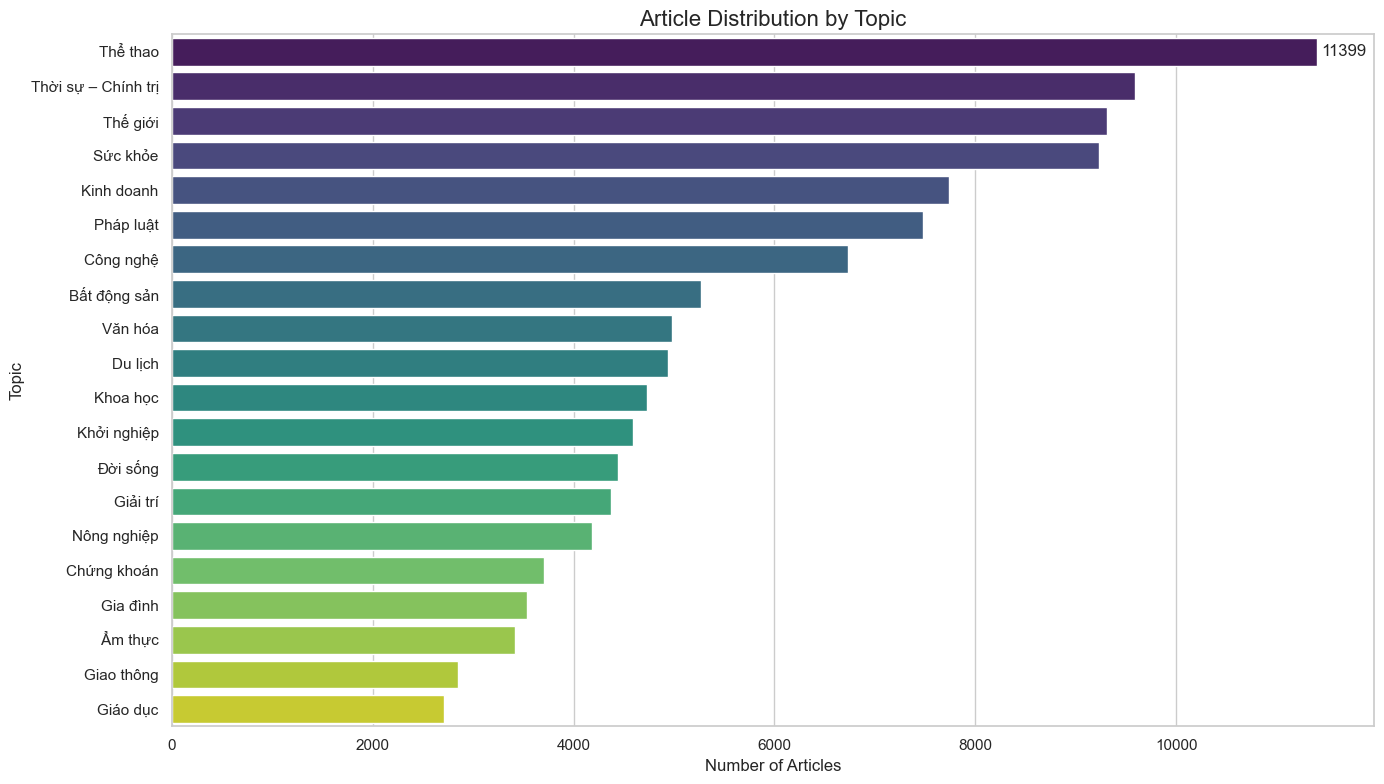

Max articles: 11399 (Thể thao)
Min articles: 2710 (Giáo dục)
Mean articles: 5759


In [3]:
# Count articles per topic
topic_counts = df['label_name'].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']

# Visualization
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=topic_counts, x='Count', y='Topic', palette='viridis', hue='Topic', legend=False)

plt.title('Article Distribution by Topic', fontsize=16)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.bar_label(ax.containers[0], padding=3)
plt.tight_layout()
plt.show()

# Statistical Summary
print(f"Max articles: {topic_counts['Count'].max()} ({topic_counts.iloc[0]['Topic']})")
print(f"Min articles: {topic_counts['Count'].min()} ({topic_counts.iloc[-1]['Topic']})")
print(f"Mean articles: {topic_counts['Count'].mean():.0f}")

                  Topic  Count  Percentage
0              Thể thao  11399    9.895996
1   Thời sự – Chính trị   9585    8.321179
2              Thế giới   9315    8.086780
3              Sức khỏe   9231    8.013856
4            Kinh doanh   7741    6.720318
5             Pháp luật   7479    6.492864
6             Công nghệ   6730    5.842622
7          Bất động sản   5268    4.573393
8               Văn hóa   4975    4.319026
9               Du lịch   4939    4.287773
10             Khoa học   4728    4.104594
11          Khởi nghiệp   4588    3.983054
12             Đời sống   4445    3.858909
13             Giải trí   4375    3.798139
14          Nông nghiệp   4182    3.630587
15          Chứng khoán   3701    3.213008
16             Gia đình   3534    3.068028
17              Ẩm thực   3413    2.962982
18           Giao thông   2850    2.474216
19             Giáo dục   2710    2.352676


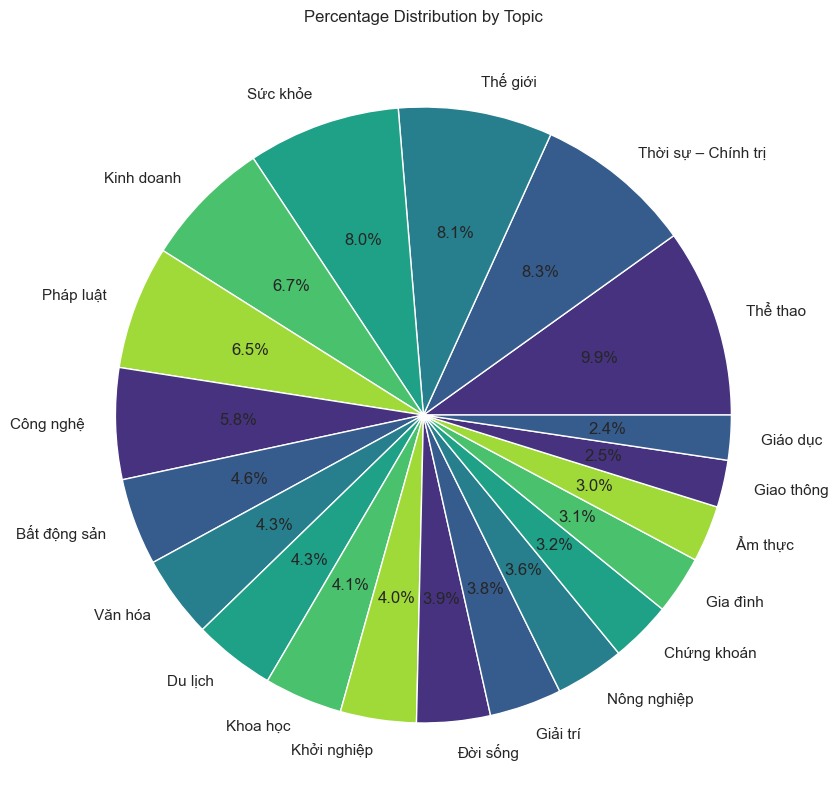

In [4]:
topic_counts['Percentage'] = (topic_counts['Count'] / topic_counts['Count'].sum()) * 100
print(topic_counts)  # In ra bảng với %

# Pie chart cho tỷ lệ
plt.figure(figsize=(10, 10))
plt.pie(topic_counts['Count'], labels=topic_counts['Topic'], autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Percentage Distribution by Topic')
plt.show()

## 4. Text Length Analysis
Analyzing the number of words per article. This helps decide the `max_length` parameter for models (e.g., BERT usually handles up to 512 tokens).

**Note:** We use a simple whitespace split to estimate word count.

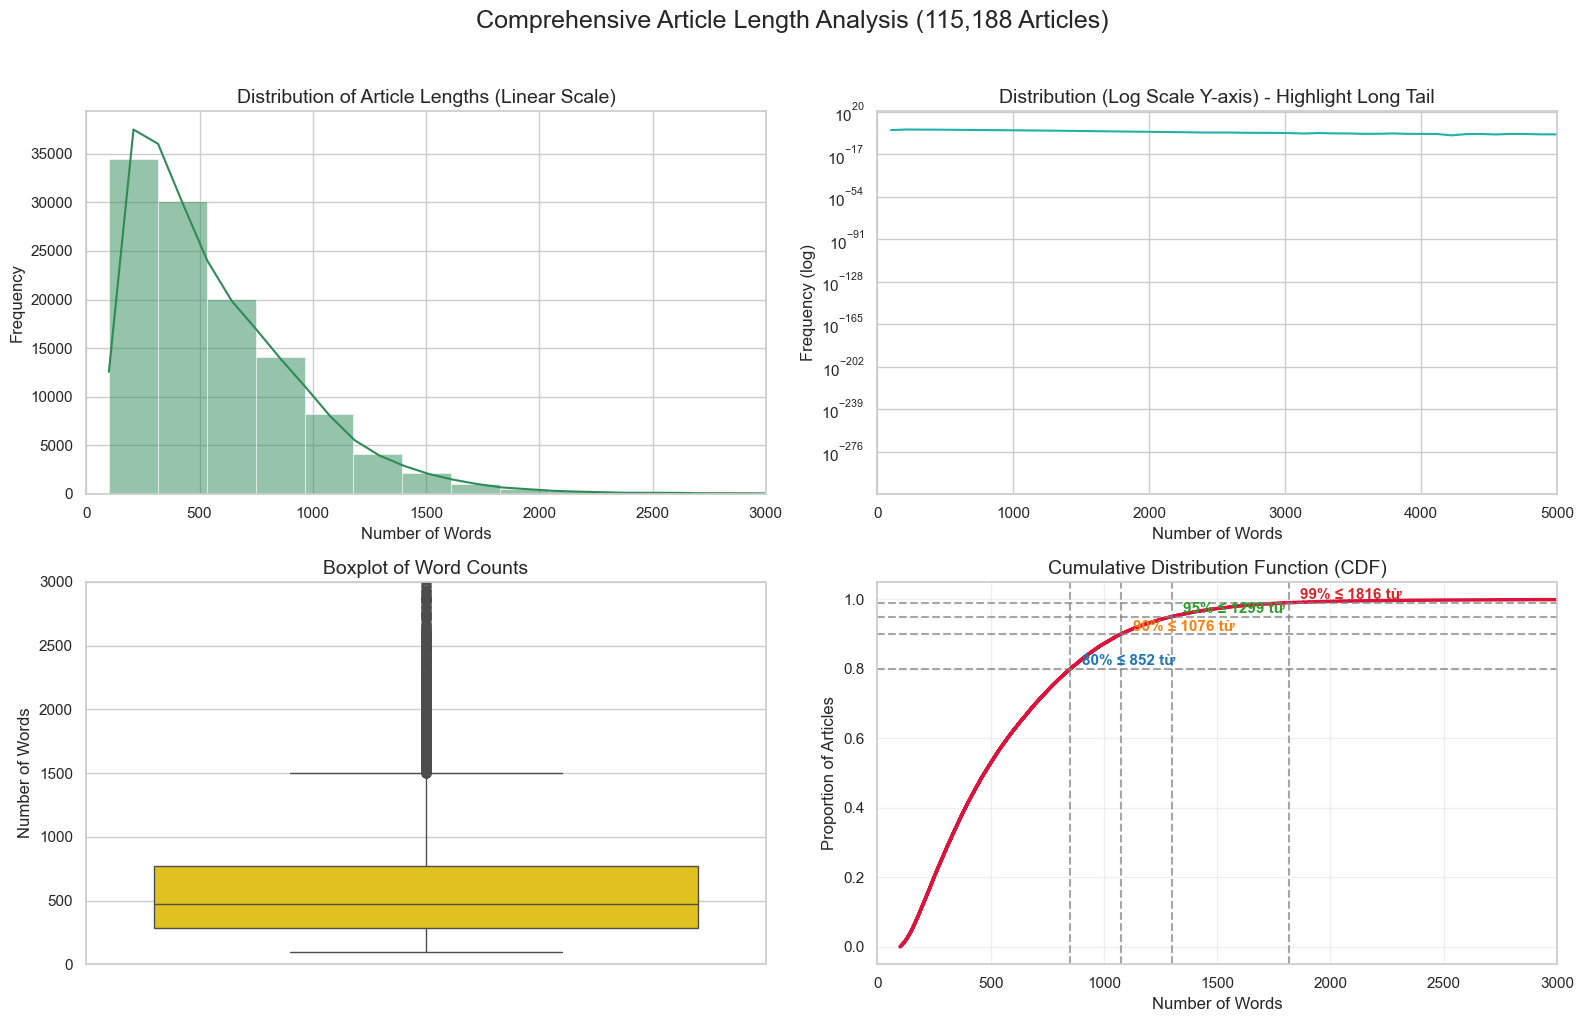

📊 Word Count Statistics
count    115188.000000
mean        574.063218
std         411.563606
min         100.000000
25%         283.000000
50%         473.000000
75%         770.000000
max       21695.000000
Name: word_count, dtype: float64

🔥 Insights tự động cho Modeling:
- 80% bài viết ≤ 852 từ
- 90% bài viết ≤ 1076 từ → có thể dùng max_length=1024 an toàn
- 95% bài viết ≤ 1299 từ → rất lý tưởng cho hầu hết model
- 97% bài viết ≤ 1463 từ
- 99% bài viết ≤ 1816 từ → chỉ 1% siêu dài
- 99.9% bài viết ≤ 3084 từ → cực hiếm
- Bài dài nhất: 21695 từ (nên kiểm tra nếu >10.000)


In [15]:
# --- TEXT LENGTH ANALYSIS - PHIÊN BẢN HOÀN CHỈNH VỚI TỰ ĐỘNG TÍNH PERCENTILE ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Đảm bảo cột word_count tồn tại và sạch
df['word_count'] = df['text'].str.split().str.len()
df['word_count'] = df['word_count'].fillna(0).astype(int)

# Tính các percentile tự động
p80 = int(np.percentile(df['word_count'], 80))
p90 = int(np.percentile(df['word_count'], 90))
p95 = int(np.percentile(df['word_count'], 95))
p97 = int(np.percentile(df['word_count'], 97))
p99 = int(np.percentile(df['word_count'], 99))
p99_9 = int(np.percentile(df['word_count'], 99.9))  # cực hiếm

# Thiết lập style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histogram linear
sns.histplot(df['word_count'], bins=100, kde=True, color='#2E8B57', ax=axes[0,0])
axes[0,0].set_title('Distribution of Article Lengths (Linear Scale)', fontsize=14)
axes[0,0].set_xlabel('Number of Words')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_xlim(0, 3000)

# 2. Histogram log scale Y
sns.histplot(df['word_count'], bins=100, kde=True, color='#20B2AA',
             log_scale=(False, True), ax=axes[0,1])
axes[0,1].set_title('Distribution (Log Scale Y-axis) - Highlight Long Tail', fontsize=14)
axes[0,1].set_xlabel('Number of Words')
axes[0,1].set_ylabel('Frequency (log)')
axes[0,1].set_xlim(0, 5000)

# 3. Boxplot
sns.boxplot(y=df['word_count'], color='#FFD700', ax=axes[1,0])
axes[1,0].set_title('Boxplot of Word Counts', fontsize=14)
axes[1,0].set_ylabel('Number of Words')
axes[1,0].set_ylim(0, 3000)

# 4. CDF với các mốc percentile tự động đánh dấu
sorted_lengths = np.sort(df['word_count'])
cdf = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)

axes[1,1].plot(sorted_lengths, cdf, color='#DC143C', linewidth=2.5)
axes[1,1].set_title('Cumulative Distribution Function (CDF)', fontsize=14)
axes[1,1].set_xlabel('Number of Words')
axes[1,1].set_ylabel('Proportion of Articles')
axes[1,1].set_xlim(0, 3000)
axes[1,1].grid(True, alpha=0.3)

# Đánh dấu các percentile quan trọng trên CDF
percentiles = [
    (0.80, p80, '80%', '#1f77b4'),
    (0.90, p90, '90%', '#ff7f0e'),
    (0.95, p95, '95%', '#2ca02c'),
    (0.99, p99, '99%', '#d62728')
]

for ratio, length, label, color in percentiles:
    axes[1,1].axhline(ratio, color='gray', linestyle='--', alpha=0.7)
    axes[1,1].axvline(length, color='gray', linestyle='--', alpha=0.7)
    axes[1,1].text(length + 50, ratio + 0.01, f'{label} ≤ {length} từ',
                   fontsize=11, color=color, weight='bold')

plt.suptitle('Comprehensive Article Length Analysis (115,188 Articles)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# In thống kê chi tiết + insight tự động
print("📊 Word Count Statistics")
print(df['word_count'].describe())

print("\n🔥 Insights tự động cho Modeling:")
print(f"- 80% bài viết ≤ {p80} từ")
print(f"- 90% bài viết ≤ {p90} từ → có thể dùng max_length=1024 an toàn")
print(f"- 95% bài viết ≤ {p95} từ → rất lý tưởng cho hầu hết model")
print(f"- 97% bài viết ≤ {p97} từ")
print(f"- 99% bài viết ≤ {p99} từ → chỉ 1% siêu dài")
print(f"- 99.9% bài viết ≤ {p99_9} từ → cực hiếm")
print(f"- Bài dài nhất: {df['word_count'].max()} từ (nên kiểm tra nếu >10.000)")

### ⚠️ Check for Anomalies
Looking for articles that are surprisingly short (potentially noise) or extremely long.

In [16]:
# Short articles check (< 50 words)
short_articles = df[df['word_count'] < 50]
print(f"⚠️ Found {len(short_articles)} articles with < 50 words.")

if not short_articles.empty:
    print("\n--- Sample Short Articles ---")
    display(short_articles[['label_name', 'word_count', 'text']].head(3))

# Long articles check (> 3000 words)
long_articles = df[df['word_count'] > 3000]
print(f"\n⚠️ Found {len(long_articles)} extremely long articles (> 3000 words).")

⚠️ Found 0 articles with < 50 words.

⚠️ Found 126 extremely long articles (> 3000 words).


## 5. Vocabulary Analysis (Word Cloud)
Visualizing the most frequent words to identify potential stop words or domain-specific terms.

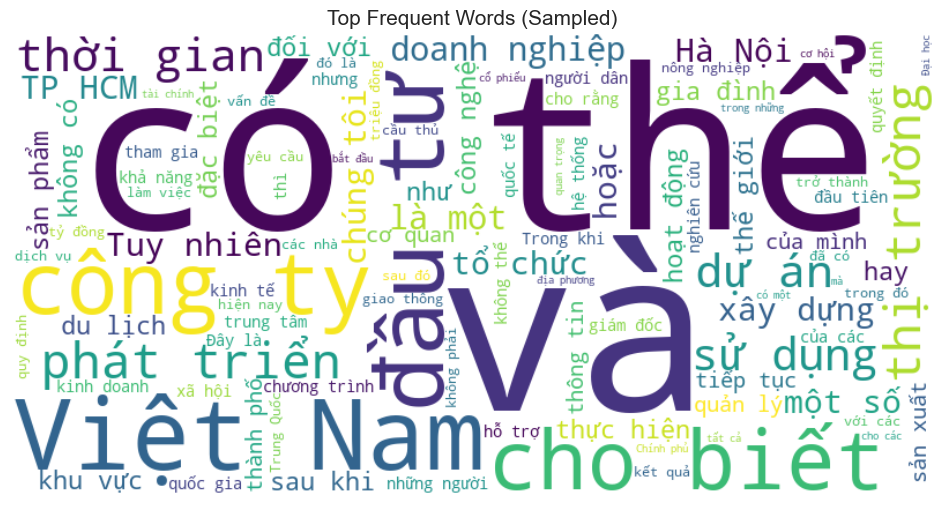

In [17]:
# Combine all text (take a sample to save RAM if dataset is huge)
sample_text = " ".join(df['text'].sample(frac=0.1, random_state=42).tolist())

# Generate WordCloud
# Note: WordCloud doesn't support Vietnamese fonts by default perfectly, 
# but works reasonably well for general analysis.
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(sample_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Frequent Words (Sampled)', fontsize=15)
plt.show()

🔍 Đang tạo word cloud cho 20 chủ đề: ['Ẩm thực', 'Bất động sản', 'Chứng khoán', 'Công nghệ', 'Du lịch', 'Gia đình', 'Giao thông', 'Giáo dục', 'Giải trí', 'Khoa học', 'Khởi nghiệp', 'Kinh doanh', 'Nông nghiệp', 'Pháp luật', 'Sức khỏe', 'Thế giới', 'Thể thao', 'Thời sự – Chính trị', 'Văn hóa', 'Đời sống']


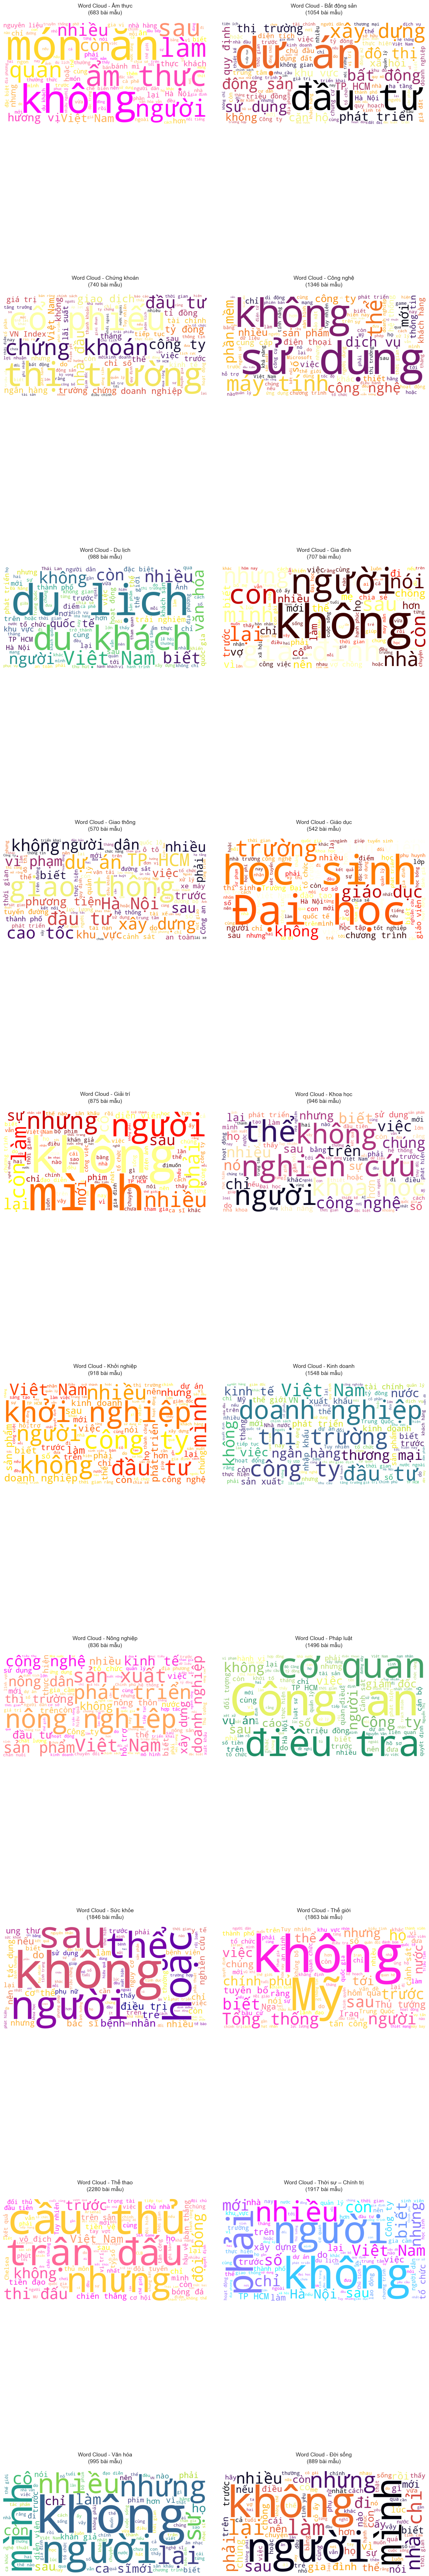

✅ Hoàn thành word cloud cho từng chủ đề!


In [14]:
# --- 5. Word Cloud per Topic ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Stop words tiếng Việt cơ bản (bạn có thể tải full list từ https://github.com/stopwords/vietnamese-stopwords)
stop_words_vi = set([
    'là', 'của', 'và', 'có', 'được', 'trong', 'một', 'cho', 'với', 'từ', 'đã', 'sẽ',
    'các', 'những', 'khi', 'đến', 'này', 'cũng', 'theo', 'như', 'bị', 'tại', 'để',
    'ông', 'bà', 'anh', 'chị', 'em', 'về', 'ra', 'lên', 'xuống', 'vào', 'ra', 'ở',
    'mà', 'hay', 'rất', 'đang', 'năm', 'ngày', 'đó', 'đây', 'thì', 'tôi', 'bạn'
    # Thêm nhiều hơn nếu cần
])

# Colormaps khác nhau cho từng topic (viridis, plasma, inferno, magma, cividis...)
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool', 'hot', 'spring', 'summer', 'autumn']

# Lấy list các chủ đề
topics = df['label_name'].unique()
print(f"🔍 Đang tạo word cloud cho {len(topics)} chủ đề: {list(topics)}")

plt.figure(figsize=(16, 10 * len(topics) // 2))  # Điều chỉnh kích thước tổng

for idx, topic in enumerate(topics):
    # Subsample 20% bài trong topic để nhanh (vẫn đủ từ vựng đại diện)
    topic_df = df[df['label_name'] == topic].sample(frac=0.2, random_state=42)

    # Ghép tất cả text lại
    text_combined = ' '.join(topic_df['text'])

    if len(text_combined) < 100:  # Nếu quá ít text
        print(f"⚠️ Chủ đề '{topic}' có quá ít dữ liệu sau sample, bỏ qua.")
        continue

    # Tạo word cloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stop_words_vi,
        colormap=random.choice(colormaps),  # Màu ngẫu nhiên khác nhau
        min_font_size=10,
        max_words=100
    ).generate(text_combined)

    # Vẽ
    plt.subplot(len(topics)//2 + len(topics)%2, 2, idx + 1)  # Grid 2 cột
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {topic}\n({len(topic_df)} bài mẫu)', fontsize=14, pad=20)
    plt.axis('off')

plt.tight_layout(pad=3.0)
plt.show()

print("✅ Hoàn thành word cloud cho từng chủ đề!")

## 6. Duplicate Check (Final Safety Net)
Even though we cleaned duplicates in Stage A, it's good practice to double-check in the final JSONL.

In [14]:
duplicates = df[df.duplicated(subset=['text'], keep=False)]
print(f"🔍 Duplicate text entries found: {len(duplicates)}")

if len(duplicates) > 0:
    print("Top duplicates:")
    display(duplicates.sort_values('text').head(4))

🔍 Duplicate text entries found: 0


## 7. Conclusion & Next Steps
Based on the analysis above:
* **Balance:** If one topic has very few samples, consider crawling more data or using augmentation.
* **Length:** If most articles are > 1000 words, we might need truncation for BERT models.
* **Cleaning:** If the WordCloud shows too many nonsense words or HTML tags, go back to `01_preprocessing.ipynb`.

**👉 Ready for:** `03_modeling.ipynb`